In [2]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

# from dataloader import image_loader, load_demo
from autoencoder import Autoencoder
from M1_util_train_test import load_model, train, test, AverageMeter
from util_model import my_loss
from exp_version import get_hp_from_version_code

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
zoomlevel = 'zoom15'
output_dim = 3
model_run_date = "2207"
sampling='stratified'
normalization = 'minmax'
data_version = '1571'
variable_names = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']
model_save_variable_names = ['totpop','pct25-34','pct35-50','pctsenior',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pctcolgrad','avg_tt_to_work','inc']
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [3]:
demo_cs, demo_np = load_demo(data_dir, norm=normalization)

In [5]:
v1 = 'F'
v2 = 1 
weight, lr, wd = get_hp_from_version_code(v1,v2)

if weight > 100:
    weightt = 1/weight
    weight = 1

else:
    weightt = 1

In [15]:
args = {'weight':weight,
        'weightt':weightt,
        'image_size': 224, 
        'depth': -1,
       'base_channels':64,
        'latent_dim': output_dim*output_dim*2048,
       'output_dim':output_dim,
       'num_demo_vars':len(variable_names),
       'demo_norm': normalization,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':lr,
       'weight_decay':wd,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[50,100]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim']),
    ('latent_dim', args['latent_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size']),
    ('demo_norm', args['demo_norm']),
    ('im_norm', 2)
])

run_config = OrderedDict([
    ('weight', args['weight']),
    ('weightt', args['weightt']),
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [7]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']

# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = run_config['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
outdir = run_config['outdir']
if not os.path.exists(outdir):
    os.makedirs(outdir)

# save config as json file in output directory
outpath = os.path.join(outdir, 'config.json')
with open(outpath, 'w') as fout:
    json.dump(config, fout, indent=2)

In [18]:
# data loaders
# train_loader, test_loader = get_loader(optim_config['batch_size'], run_config['num_workers'])
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         112,#data_config['image_size'], 
                                         data_version=data_version, sampling=sampling, 
                                         recalculate_normalize=False)

28278 images in dataset
3142 images in dataset


In [27]:
for step, (image_list, data) in enumerate(train_loader):
    break
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.3733/0.2173, -0.3991/0.2055, -0.3711/0.2143],
    std=[1/0.2173, 1/0.2055, 1/0.2143]
)    

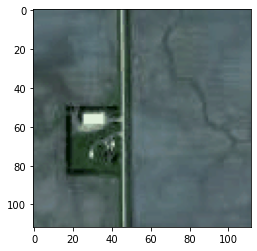

In [32]:
plt.imshow(inv_normalize(data[6,:,:,:]).permute(1,2,0).detach().cpu().numpy())


In [8]:
#criterion = nn.MSELoss(reduction='mean')
criterion = my_loss

In [16]:
# model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config)
encoder = encoder.to(device)

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['data_config']['color_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config)
decoder = decoder.to(device)

config['encoder'] = encoder
config['decoder'] = decoder
model = load_model('autoencoder','Autoencoder', config)
model = model.to(device)

In [17]:
decoder

Decoder(
  (stage1): Sequential(
    (block1): DeconvBottleneckBlock(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (conv): ConvTranspose2d(1024, 512, kernel_size=(1, 1), stride=(2, 2), output_padding=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (block2): DeconvBottleneckBlock(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
for step, (image_list, data) in enumerate(train_loader):

#     census_index = [demo_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
#     census_data = demo_np[census_index]

#     census_data = torch.tensor(census_data).to(device)
#     data = data.to(device)

#     optimizer.zero_grad()

    data = data.to(device)
    break

In [38]:
data.shape

torch.Size([16, 3, 224, 224])

In [13]:
encoder(data);

torch.Size([16, 64, 112, 112])
torch.Size([16, 64, 56, 56])
torch.Size([16, 256, 56, 56])
torch.Size([16, 512, 28, 28])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 2048, 7, 7])
torch.Size([16, 2048, 3, 3])


In [15]:
model(data);

torch.Size([16, 64, 112, 112])
torch.Size([16, 64, 56, 56])
torch.Size([16, 256, 56, 56])
torch.Size([16, 512, 28, 28])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 2048, 7, 7])
torch.Size([16, 2048, 3, 3])
torch.Size([16, 2048, 7, 7])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 512, 28, 28])
torch.Size([16, 256, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 64, 112, 112])
torch.Size([16, 3, 224, 224])


In [22]:
config['model_config']['conv_shape']

[7, 7]

In [10]:
n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) +\
           sum([param.view(-1).size()[0] for param in decoder.parameters()])
logger.info('n_params: {}'.format(n_params))

# optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=optim_config['base_lr'],
    momentum=optim_config['momentum'],
    weight_decay=optim_config['weight_decay'],
    nesterov=optim_config['nesterov'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=optim_config['milestones'],
    gamma=optim_config['lr_decay'])

[2022/07/24 00:23:07 __main__ INFO] - n_params: 31961862


In [ ]:
# Test with Adam Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=optim_config['base_lr'],
#                              weight_decay=optim_config['weight_decay'])

# run test before start training
# test_outputs = test(0, model, criterion, test_loader, run_config, writer, device)

ref1 = 0
ref2 = 0

train_loss_list = []
test_loss_list = []

train_flag = True

run_config['scheduler'] = scheduler
    
for epoch in range(args['epochs']):

    loss_ = train(epoch, model, optimizer, criterion, train_loader, (demo_cs,demo_np), run_config,
         writer, device, logger=logger)
    train_loss_list.append(loss_)
    
    scheduler.step()

    test_loss_ = test(epoch, model, criterion, test_loader, (demo_cs,demo_np), run_config,
                    writer, device, logger, return_output=False)
    test_loss_list.append(test_loss_)
    
    model.eval()
    loss_meter_1 = AverageMeter()
    loss_meter_2 = AverageMeter()

    for step, (image_list, data) in enumerate(test_loader):

        census_index = [demo_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
        census_data = demo_np[census_index]

        census_data = torch.tensor(census_data).to(device)
        data = data.to(device)

        out_image, out_demo = model(data)

        loss1, loss2 = criterion(out_image, out_demo, data, census_data, return_components=True)

        num = data.size(0)

        loss_meter_1.update(loss1.item(), num)
        loss_meter_2.update(loss2.item(), num)

#         if step % 10 == 0:
#             print(step, end='\t')

    best_test_1 = loss_meter_1.avg
    best_test_2 = loss_meter_2.avg
    print(best_test_1, best_test_2)         

    loss_meter_1 = AverageMeter()
    loss_meter_2 = AverageMeter() 
    
    for step, (image_list, data) in enumerate(train_loader):

        census_index = [demo_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
        census_data = demo_np[census_index]

        census_data = torch.tensor(census_data).to(device)
        data = data.to(device)

        out_image, out_demo = model(data)

        loss1, loss2 = criterion(out_image, out_demo, data, census_data, return_components=True)

        num = data.size(0)

        loss_meter_1.update(loss1.item(), num)
        loss_meter_2.update(loss2.item(), num)

#         if step % 10 == 0:
#             print(step, end='\t')

    best_1 = loss_meter_1.avg
    best_2 = loss_meter_2.avg
    print(best_1, best_2)
    
    if epoch % 5 == 0:
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<0.0001) & (np.abs(loss_ - ref2)/ref2<0.0001):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                train_flag = False
                break
            if loss_ < best:
                best = loss_
                best_epoch = epoch
        else:
            best = loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': config},
                model_dir+"SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v1)+"_"+str(v2)+"_"+
                model_run_date+"_"+str(epoch)+".pt")

            
if config['run_config']['save']:
    files = glob.glob(model_dir+"SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                              str(v1)+"_"+str(v2)+"_"+model_run_date+"_*.pt")

    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)

        
if run_config['tensorboard']:
    outpath = os.path.join(outdir, 'all_scalars.json')
    writer.export_scalars_to_json(outpath)
    

[2022/07/24 00:25:23 __main__ INFO] - Epoch 0 Step 883/884 Train Loss 0.03733715
[2022/07/24 00:25:28 __main__ INFO] - Epoch 0 Test Loss 0.04107460
[2022/07/24 00:25:28 __main__ INFO] - Elapsed 5.65


7.2764716889735315 0.03379813076117043
5.713462040088615 0.033766770775264916


[2022/07/24 00:28:37 __main__ INFO] - Epoch 1 Step 883/884 Train Loss 0.03519213
[2022/07/24 00:28:42 __main__ INFO] - Epoch 1 Test Loss 0.03664240
[2022/07/24 00:28:42 __main__ INFO] - Elapsed 5.17


3.32395226427281 0.03331844539504131
3.061000216259327 0.03329844256075737


[2022/07/24 00:31:52 __main__ INFO] - Epoch 2 Step 883/884 Train Loss 0.03467630
[2022/07/24 00:31:57 __main__ INFO] - Epoch 2 Test Loss 0.03522063
[2022/07/24 00:31:57 __main__ INFO] - Elapsed 5.24


2.387338914399235 0.032833295434167076
2.217796912539991 0.032849248864944024


[2022/07/24 00:35:08 __main__ INFO] - Epoch 3 Step 883/884 Train Loss 0.03412001
[2022/07/24 00:35:13 __main__ INFO] - Epoch 3 Test Loss 0.03619821
[2022/07/24 00:35:13 __main__ INFO] - Elapsed 5.25


4.0961357471974775 0.032102077410886436
3.7422242435001656 0.03214626054507809


[2022/07/24 00:38:24 __main__ INFO] - Epoch 4 Step 883/884 Train Loss 0.03362259
[2022/07/24 00:38:29 __main__ INFO] - Epoch 4 Test Loss 0.03610151
[2022/07/24 00:38:29 __main__ INFO] - Elapsed 5.32


4.432297008573288 0.03166921648887648
4.1119587712632235 0.031704786552848536


[2022/07/24 00:41:41 __main__ INFO] - Epoch 5 Step 883/884 Train Loss 0.03314229
[2022/07/24 00:41:46 __main__ INFO] - Epoch 5 Test Loss 0.03453793
[2022/07/24 00:41:46 __main__ INFO] - Elapsed 5.28


3.426516869127333 0.03111141080065744
3.0721781758002793 0.031149847031952123


[2022/07/24 00:44:57 __main__ INFO] - Epoch 6 Step 883/884 Train Loss 0.03262020
[2022/07/24 00:45:03 __main__ INFO] - Epoch 6 Test Loss 0.03292370
[2022/07/24 00:45:03 __main__ INFO] - Elapsed 5.23


2.4050185364344405 0.030518676134507983
2.200078445834447 0.030594847315551482


[2022/07/24 00:48:14 __main__ INFO] - Epoch 7 Step 883/884 Train Loss 0.03211652
[2022/07/24 00:48:19 __main__ INFO] - Epoch 7 Test Loss 0.03208848
[2022/07/24 00:48:19 __main__ INFO] - Elapsed 5.31


2.032127785348801 0.030056348975953474
1.8661041776221177 0.03015481447458581


[2022/07/24 00:51:30 __main__ INFO] - Epoch 8 Step 883/884 Train Loss 0.03175178
[2022/07/24 00:51:35 __main__ INFO] - Epoch 8 Test Loss 0.03469533
[2022/07/24 00:51:35 __main__ INFO] - Elapsed 5.23


4.926444687636926 0.029768886305795293
4.44673255086999 0.029879468102771575


[2022/07/24 00:54:46 __main__ INFO] - Epoch 9 Step 883/884 Train Loss 0.03126040
[2022/07/24 00:54:52 __main__ INFO] - Epoch 9 Test Loss 0.03217815
[2022/07/24 00:54:52 __main__ INFO] - Elapsed 5.27


3.174867053042545 0.029003287118270472
2.959516162388024 0.029135228240276763


[2022/07/24 00:58:03 __main__ INFO] - Epoch 10 Step 883/884 Train Loss 0.03096859
[2022/07/24 00:58:08 __main__ INFO] - Epoch 10 Test Loss 0.03102370
[2022/07/24 00:58:08 __main__ INFO] - Elapsed 5.29


2.377662019772108 0.02864603416419453
2.1523543757894554 0.028781019278679813


[2022/07/24 01:01:20 __main__ INFO] - Epoch 11 Step 883/884 Train Loss 0.03060854
[2022/07/24 01:01:25 __main__ INFO] - Epoch 11 Test Loss 0.03042867
[2022/07/24 01:01:25 __main__ INFO] - Elapsed 5.26


2.4107950420458555 0.0280178711828223
2.2459799015789272 0.02825649956414049


[2022/07/24 01:04:36 __main__ INFO] - Epoch 12 Step 883/884 Train Loss 0.03025205
[2022/07/24 01:04:41 __main__ INFO] - Epoch 12 Test Loss 0.03288794
[2022/07/24 01:04:41 __main__ INFO] - Elapsed 5.30


5.215494593414511 0.027672439995160916
4.871627332179615 0.027895666511168725


[2022/07/24 01:07:52 __main__ INFO] - Epoch 13 Step 883/884 Train Loss 0.02980989
[2022/07/24 01:07:57 __main__ INFO] - Epoch 13 Test Loss 0.02963756
[2022/07/24 01:07:57 __main__ INFO] - Elapsed 5.29


2.5745061038407 0.027063050587410886
2.29651515181512 0.02719161818425493


[2022/07/24 01:11:08 __main__ INFO] - Epoch 14 Step 883/884 Train Loss 0.02904766
[2022/07/24 01:11:13 __main__ INFO] - Epoch 14 Test Loss 0.02850855
[2022/07/24 01:11:13 __main__ INFO] - Elapsed 5.28


2.689830011770575 0.025818724790390664
2.466260993950302 0.026013973643517308


[2022/07/24 01:14:24 __main__ INFO] - Epoch 15 Step 883/884 Train Loss 0.02825085
[2022/07/24 01:14:29 __main__ INFO] - Epoch 15 Test Loss 0.02715802
[2022/07/24 01:14:29 __main__ INFO] - Elapsed 5.30


2.600903816582821 0.024557119997253046
2.476600513489279 0.02458006312039343


In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(train_loss_list, color='cornflowerblue', label='Train')
ax.plot(test_loss_list, color='sandybrown', label='Test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 1.1*np.max(train_loss_list+test_loss_list)])
ax.legend()
plt.show()
fig.savefig(out_dir+"training_plots/SAE_"+model_run_date+".png", bbox_inches='tight')

In [ ]:
model.eval()
loss_meter_1 = AverageMeter()
loss_meter_2 = AverageMeter()

for step, (image_list, data) in enumerate(test_loader):

    census_index = [demo_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
    census_data = demo_np[census_index]

    census_data = torch.tensor(census_data).to(device)
    data = data.to(device)

    out_image, out_demo = model(data)

    loss1, loss2 = criterion(out_image, out_demo, data, census_data, return_components=True)

    num = data.size(0)

    loss_meter_1.update(loss1.item(), num)
    loss_meter_2.update(loss2.item(), num)

    if step % 10 == 0:
        print(step, end='\t')

best_test_1 = loss_meter_1.avg
best_test_2 = loss_meter_2.avg
print(best_test_1, best_test_2)         

loss_meter_1 = AverageMeter()
loss_meter_2 = AverageMeter()                                                              
for step, (image_list, data) in enumerate(train_loader):

    census_index = [demo_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
    census_data = demo_np[census_index]

    census_data = torch.tensor(census_data).to(device)
    data = data.to(device)

    out_image, out_demo = model(data)

    loss1, loss2 = criterion(out_image, out_demo, data, census_data, return_components=True)

    num = data.size(0)

    loss_meter_1.update(loss1.item(), num)
    loss_meter_2.update(loss2.item(), num)

    if step % 10 == 0:
        print(step, end='\t')

best_1 = loss_meter_1.avg
best_2 = loss_meter_2.avg
print(best_1, best_2)

0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	0.40756353766276227 0.010623590972356966
0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	210	220	230	240	250	260	270	280	290	300	310	320	330	340	350	360	370	380	390	400	410	420	430	440	450	460	470	480	490	500	510	520	530	540	550	560	570	580	590	600	610	620	630	640	650	660	670	680	690	700	710	720	730	740	750	760	770	780	790	800	810	820	830	840	850	860	870	880	890	900	910	920	930	940	950	960	970	980	990	1000	1010	1020	1030	1040	1050	1060	1070	1080	1090	1100	1110	1120	1130	1140	1150	1160	1170	1180	1190	1200	1210	1220	1230	1240	1250	1260	1270	1280	1290	1300	1310	1320	1330	1340	1350	1360	1370	1380	1390	1400	1410	1420	1430	1440	1450	1460	1470	1480	1490	1500	1510	

In [ ]:
with open(out_dir+"SAE_train.csv", "a") as f:
    f.write("%s,%s,%d,%s,%s,%d,%.4f,%.4f,%.4f,%.4f,%d\n" % (model_run_date, zoomlevel, model_config['output_dim']**2*2048, 
            sampling, normalization, best_epoch, best_1, best_2, best_test_1, best_test_2, train_flag))

In [ ]:
# Reverse Normalization

# CIFAR
# inv_normalize = torchvision.transforms.Normalize(
#     mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
#     std=[1/0.2470, 1/0.2435, 1/0.2616]
# )


# Satellite image
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.3733/0.2173, -0.3991/0.2055, -0.3711/0.2143],
    std=[1/0.2173, 1/0.2055, 1/0.2143]
)

In [ ]:
for step, (_,data) in enumerate(test_loader):
    data = data.to(device)
    test_output = model(data)
    test_output_orig = inv_normalize(test_output)
    data_orig = inv_normalize(data)
    if step == 0:
        break

In [ ]:
plot_image = 15

In [ ]:
plt.hist(data[plot_image, :, :, :].cpu().detach().numpy().flatten())

In [ ]:
plt.hist(test_output[plot_image, :, :, :].cpu().detach().numpy().flatten())

In [ ]:
torch.mean(test_output[:,0,:,:])

In [ ]:
torch.mean(test_output[:,1,:,:])

In [ ]:
torch.mean(test_output[:,2,:,:])

In [ ]:
torch.mean(data[:,0,:,:])

In [ ]:
torch.mean(data[:,1,:,:])

In [ ]:
torch.mean(data[:,1,:,:])

In [ ]:
np.mean((test_output - data).detach().cpu().numpy()[:,0,:,:])

In [ ]:
np.mean((test_output - data).detach().cpu().numpy()[:,1,:,:])

In [ ]:
np.mean((test_output - data).detach().cpu().numpy()[:,2,:,:])

In [ ]:
np.mean((test_output - data).cpu().detach().numpy())

In [ ]:
np.mean(np.power((test_output - data).cpu().detach().numpy(), 2))

In [ ]:
plt.hist((test_output - data).detach().cpu().numpy()[:,2,:,:].flatten())

In [ ]:
plt.hist((test_output - data).detach().cpu().numpy()[:,1,:,:].flatten());

In [ ]:
plt.hist((test_output - data).detach().cpu().numpy()[:,0,:,:].flatten())

In [ ]:
test_output_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0).numpy()

In [ ]:
data_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0).numpy()

In [ ]:
plot_image = 3

In [ ]:
plt.imshow(test_output_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0))
plt.axis('off');

In [ ]:
plt.imshow(data_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0));
plt.axis('off');

In [ ]:
model

In [ ]:
plt.hist(data.detach().numpy()[:,0,:,:].flatten())